In [1]:
from matplotlib import pyplot as plt
from utils.utils import *
import utils.promethee_functions as pf
import utils.clustering_functions as cf

data = read_data()

group0 = ["PAK", "SDN", "BDI", "HTI"]
group1 = ["EST", "CZE", "MLT", "SGP", "IRL"]
group2 = ["CHE", "ISL", "NZL", "SWE"]

all_groups = group0 + group1 + group2

data = data.loc[all_groups]

# Nb of criteria
K = data.columns.shape[0] # Nb of criteria
L = data.iloc[0]["co2prod"].shape[0] # Length of the time series

W = [1/K for i in range(K)] # Weights of the criteria (equal weights)
Q = [10, 0.3, 40,  0.4, 4, 2] # Indifference thresholds
P = [28, 0.9, 80, 1, 18, 12] # Preference thresholds

data.head(3)

utils.py Loading
Reading HDI dataset
co2prod: min=0.0, max=33.3863
hdi: min=0.257, max=0.967
le: min=37.105, max=85.473
gdi: min=0.383, max=1.041
eys: min=3.5751, max=23.2477
mys: min=1.4606, max=14.2559


,co2prod,hdi,le,gdi,eys,mys
iso3,,,,,,
PAK,"[32.817923848999996, 32.839545195, 32.81713493...","[0.394, 0.399, 0.403, 0.405, 0.409, 0.411, 0.4...","[60.066, 60.259, 60.116, 59.934, 60.116, 59.87...","[0.539, 0.57, 0.576, 0.585, 0.598, 0.589, 0.60...","[4.238239765, 4.280649002, 4.323058238, 4.3654...","[2.291861259, 2.390371085, 2.488880911, 2.5873..."
SDN,"[33.179499414999995, 33.197418881, 33.22244834...","[0.322, 0.328, 0.318, 0.328, 0.371, 0.361, 0.3...","[49.732, 50.213, 45.891, 46.575, 56.644, 51.99...","[0.755, 0.76, 0.795, 0.805, 0.762, 0.794, 0.80...","[3.575123192, 3.716464477, 3.863393641, 4.0161...","[1.5, 1.594, 1.688, 1.782, 1.876, 1.97, 2.064,..."
BDI,"[33.367526346999995, 33.363043413999996, 33.36...","[0.285, 0.287, 0.284, 0.257, 0.288, 0.284, 0.2...","[44.86, 44.227, 43.895, 37.105, 44.08, 44.059,...","[0.822, 0.824, 0.814, 0.832, 0.823, 0.829, 0.8...","[4.218900204, 4.333489895, 4.203050137, 4.4798...","[1.460590005, 1.514265001, 1.567939997, 1.6216..."


In [24]:
def K_Medoid_Eta(alternatives, distance_matrix, k=3, prototype_method="random", print_results=True):
    """ 
    K-Medoid clustering algorithm using the Aggregated Eta matrix
        - alternatives: np.array of the alternatives names only
        - distance_matrix: pd.DataFrame of the distance matrix with index and columns as the alternatives names
        - k: the number of clusters

    Returns:
        - the medoids of the clusters
        - the clusters
    """
    # Initialize medoids
    if prototype_method == "random":
        medoids = np.random.choice(alternatives, k, replace=False) # Randomly select k alternatives

    elif prototype_method == "farthest":
        # Select the farthest alternatives from each other
        medoids = [alternatives[0]]
        for _ in range(k-1):
            distances = [np.min([distance_matrix.loc[alternative, medoid] for medoid in medoids]) for alternative in alternatives]
            new_medoid = alternatives[np.argmax(distances)]
            medoids.append(new_medoid)

    elif prototype_method == "defined":
        medoids = ["ISL", "MLT", "PAK"]
        # Transform into np.array
        medoids = np.array(medoids)


    if print_results:
        print("Initial medoids:", medoids)

    # Initialize clusters
    clusters = {medoid: [] for medoid in medoids}

    iter = 0
    # Iterate until convergence
    converged = False
    while not converged and iter < 100:
        # print(f"Iteration {iter}")
        iter += 1

        # Assign each alternative to the closest medoid
        for alternative in alternatives:
            distances = [distance_matrix.loc[alternative, medoid] for medoid in medoids]
            closest_medoid = medoids[np.argmin(distances)]
            clusters[closest_medoid].append(alternative)

        # Update medoids
        converged = True
        for medoid in medoids:
            cluster = clusters[medoid] # Alternatives in the cluster
            distances = [np.sum([distance_matrix.loc[alternative1, alternative2] for alternative1 in cluster]) for alternative2 in cluster] # Sum of distances to all other alternatives in the cluster
            new_medoid = cluster[np.argmin(distances)] # Alternative with the smallest sum of distances
            if new_medoid != medoid: # If the medoid has changed
                # Index of the new medoid in the medoids list
                medoids[np.where(medoids == medoid)[0][0]] = new_medoid # Replace the medoid
                clusters = {medoid: [] for medoid in medoids} # Reset the clusters
                converged = False # The algorithm has not converged -> continue the iterations
                # print("New medoid:", new_medoid, " replaces Old medoid:", medoid)
                break # Stop the loop and start a new iteration, this stops the loop:
    
    if iter == 100:
        if print_results:
            print("The algorithm did not converge after 100 iterations, assigning the closest alternatives to the medoids")
        # Assign each alternative to the closest medoid
        for alternative in alternatives:
            distances = [distance_matrix.loc[alternative, medoid] for medoid in medoids]
            closest_medoid = medoids[np.argmin(distances)]
            clusters[closest_medoid].append(alternative)

    return medoids, clusters, iter

In [26]:
def get_clusters_evolution(data, P, Q, W, K, L, k=3):
    """ 
    Get the evolution of the clusters over time using the K-Medoids with Eta distances
    - data: Dataframe with the alternatives
    - P: Preference thresholds
    - Q: Indifference thresholds
    - W: Weights of the criteria
    - K: Number of criteria
    - L: Length of the time series
    - k: Number of clusters to form (for the K-Medoids algorithm)
    """

    alternatives = data.index
    # Get the temporal_eta matrix
    phi_c_all = pf.get_all_Phi_c(data, P, Q)
    temporal_eta = pf.get_eta_matrix(data, phi_c_all, W)

    # Get the clusters evolution
    clusters_evolution = []
    medoids_evolution = []
    iterations = []

    for t in tqdm(range(L)):
        eta_matrix = temporal_eta[:,:,t]
        eta_matrix = pd.DataFrame(eta_matrix, index=alternatives, columns=alternatives)
        medoids, clusters, _ = K_Medoid_Eta(alternatives, eta_matrix, k, prototype_method="defined", print_results=False)
        clusters_evolution.append(clusters)
        medoids_evolution.append(medoids)
        iterations.append(t)

    return clusters_evolution, medoids_evolution, iterations

clusters_evolution, medoids_evolution, iterations = get_clusters_evolution(data, P, Q, W, K, L, k=3)

c:\Users\raphu\Documents\ULB\MA2\ulb-master-thesis\code\src\utils\promethee_functions.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = a_i[c] - a_j[c]
100%|██████████| 33/33 [00:00<00:00, 86.01it/s] 


In [27]:
def transform_clusters_evolutions(clusters_evolution):
    """
    Transform the clusters evolution into a dataframe
    - clusters_evolution: List of the clusters evolution over time
    """
    evol = []
    for i in clusters_evolution:
        temp = []
        for key, value in i.items():
            temp.append(value)
        evol.append(temp)
    return pd.DataFrame(evol)

clusters_evolution_df = transform_clusters_evolutions(clusters_evolution)
clusters_evolution_df

,0,1,2
0,"[CHE, ISL, SWE]","[HTI, EST, CZE, MLT, SGP, IRL, NZL]","[PAK, SDN, BDI]"
1,"[CHE, ISL, NZL, SWE]","[EST, CZE, MLT, SGP, IRL]","[PAK, SDN, BDI, HTI]"
2,"[CHE, ISL, NZL]","[EST, CZE, MLT, SGP, IRL, SWE]","[PAK, SDN, BDI, HTI]"
3,"[CHE, ISL, NZL, SWE]","[EST, CZE, MLT, SGP, IRL]","[PAK, SDN, BDI, HTI]"
4,"[CHE, ISL, NZL, SWE]","[EST, CZE, MLT, SGP, IRL]","[PAK, SDN, BDI, HTI]"
5,"[EST, CHE, ISL, NZL, SWE]","[CZE, MLT, SGP, IRL]","[PAK, SDN, BDI, HTI]"
6,"[CHE, ISL, NZL, SWE]","[EST, CZE, MLT, SGP, IRL]","[PAK, SDN, BDI, HTI]"
7,"[CHE, ISL, NZL, SWE]","[EST, CZE, MLT, SGP, IRL]","[PAK, SDN, BDI, HTI]"
8,"[EST, ISL, NZL, SWE]","[HTI, CZE, MLT, SGP, IRL, CHE]","[PAK, SDN, BDI]"
9,"[EST, ISL, NZL, SWE]","[CZE, MLT, SGP, IRL, CHE]","[PAK, SDN, BDI, HTI]"


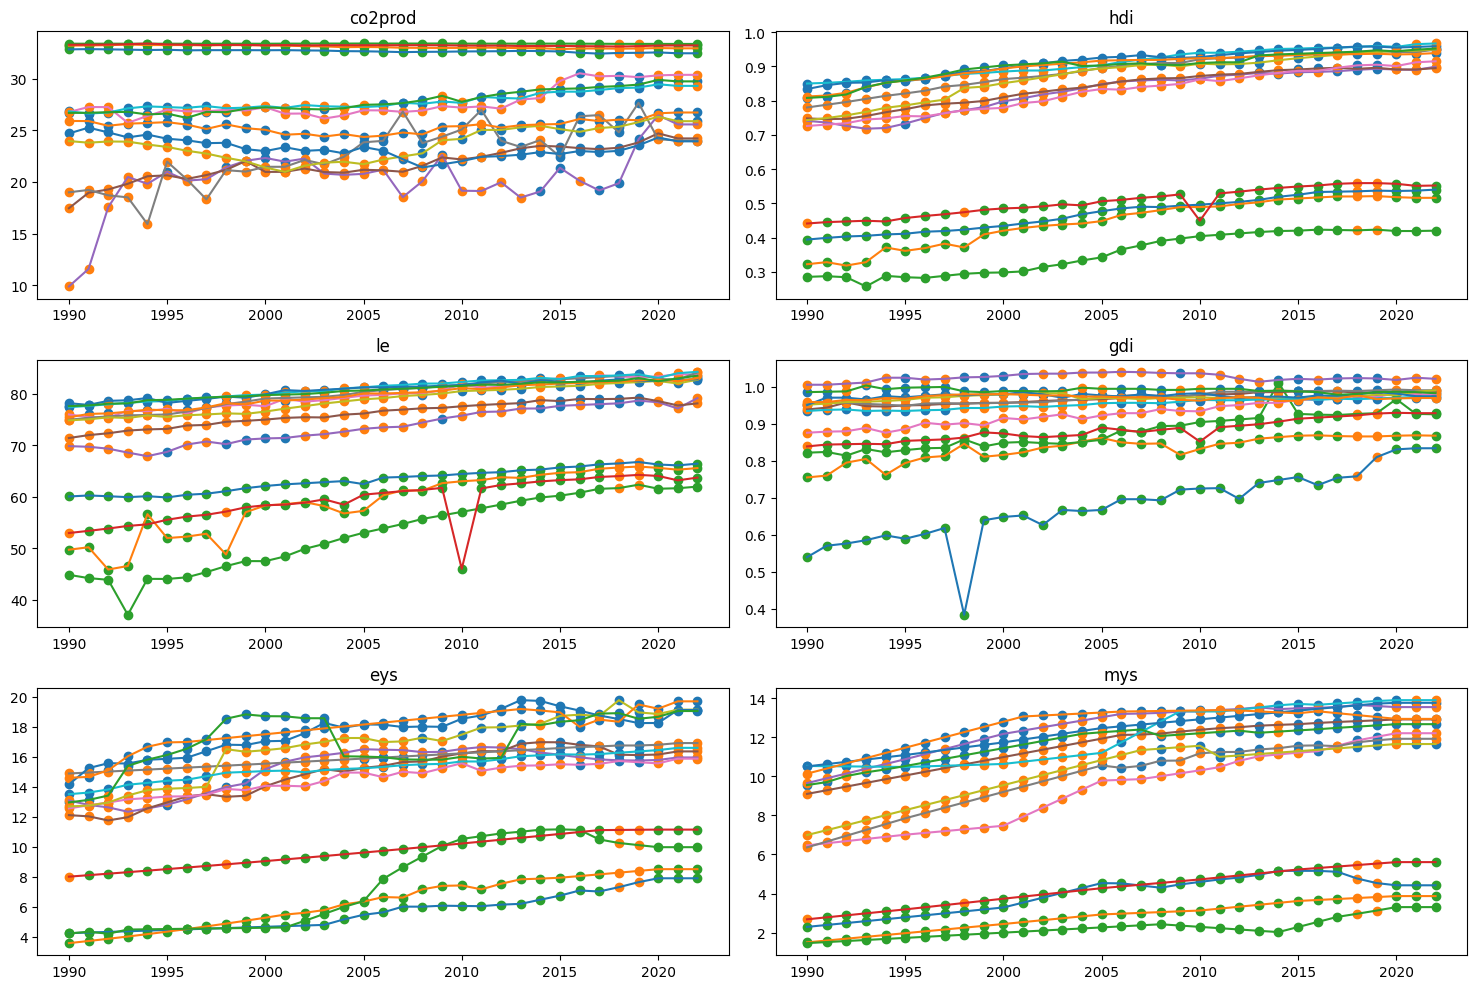

In [41]:
def plot_cluster_evolution(cluster_evolution_df, data, legend=False):
    """ 
    Plot the evolution of the clusters over time
    - cluster_evolution_df: Dataframe with the clusters evolution over time	
        - rows: time steps t
        - columns: clusters i
        - values: list of alternatives in the cluster i at time t
    - data: Dataframe with the 
    
    Print clusters by color (i.e. cluster 0 in blue, cluster 1 in red, etc.)
    But the color of the countries in the cluster is not consistent over time

    """
    x = np.arange(1990, 2023)
    Nb_cols = len(data.columns)
    fig, axs = plt.subplots((Nb_cols + 1) // 2, 2, figsize=(15, 10))
    axs = axs.flatten()

    for i, col in enumerate(data.columns[:]): # Loop over the columns of the data (criteria)
        for _, row in data.iterrows():
            axs[i].plot(x, row[col], label=row.name) 
        for t in cluster_evolution_df.index: # Loop over the time steps
            for j, cluster in enumerate(cluster_evolution_df.loc[t]): # Loop over the clusters
                if cluster != None:
                    for country in cluster: # Loop over the countries in the cluster
                        if country in data.index:
                            axs[i].scatter(x[t], data.loc[country, col][t], color=f"C{j}", label=f"Cluster {j}")
        axs[i].set_title(col)
        if legend:
            axs[i].legend()  # Add legend here


    plt.tight_layout()
    plt.show()

plot_cluster_evolution(clusters_evolution_df, data, legend=False)